In [21]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [22]:
import os
import pandas as pd

# Define the dataset directory path
data_dir = r"C:\Users\krant\OneDrive\Desktop\Blood_cell_dataset"

# Define the class labels
class_labels = ['EOS 0001-1000', 'LYT 0001-1000', 'MON 0001-1000', 'NGS 0001-1000']

# Initialize lists to hold file paths and labels
filepaths = []
labels = []

# Loop through each class directory and gather file paths and labels
for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    for file in os.listdir(class_dir):
        if file.endswith(".jpeg") or file.endswith(".jpg") or file.endswith(".png"):
            filepaths.append(os.path.join(class_dir, file))
            labels.append(label)

# Create a DataFrame from the file paths and labels
bloodcell_df = pd.DataFrame({
    "Filepaths": filepaths,
    "Labels": labels
})

# Shuffle the dataset
bloodcell_df = bloodcell_df.sample(frac=1).reset_index(drop=True)

# Display the first few rows of the DataFrame
print(bloodcell_df.head())


                                           Filepaths         Labels
0  C:\Users\krant\OneDrive\Desktop\Blood_cell_dat...  LYT 0001-1000
1  C:\Users\krant\OneDrive\Desktop\Blood_cell_dat...  LYT 0001-1000
2  C:\Users\krant\OneDrive\Desktop\Blood_cell_dat...  LYT 0001-1000
3  C:\Users\krant\OneDrive\Desktop\Blood_cell_dat...  EOS 0001-1000
4  C:\Users\krant\OneDrive\Desktop\Blood_cell_dat...  MON 0001-1000


Batch image shape: (8, 244, 244, 3)
Batch label shape: (8, 4)


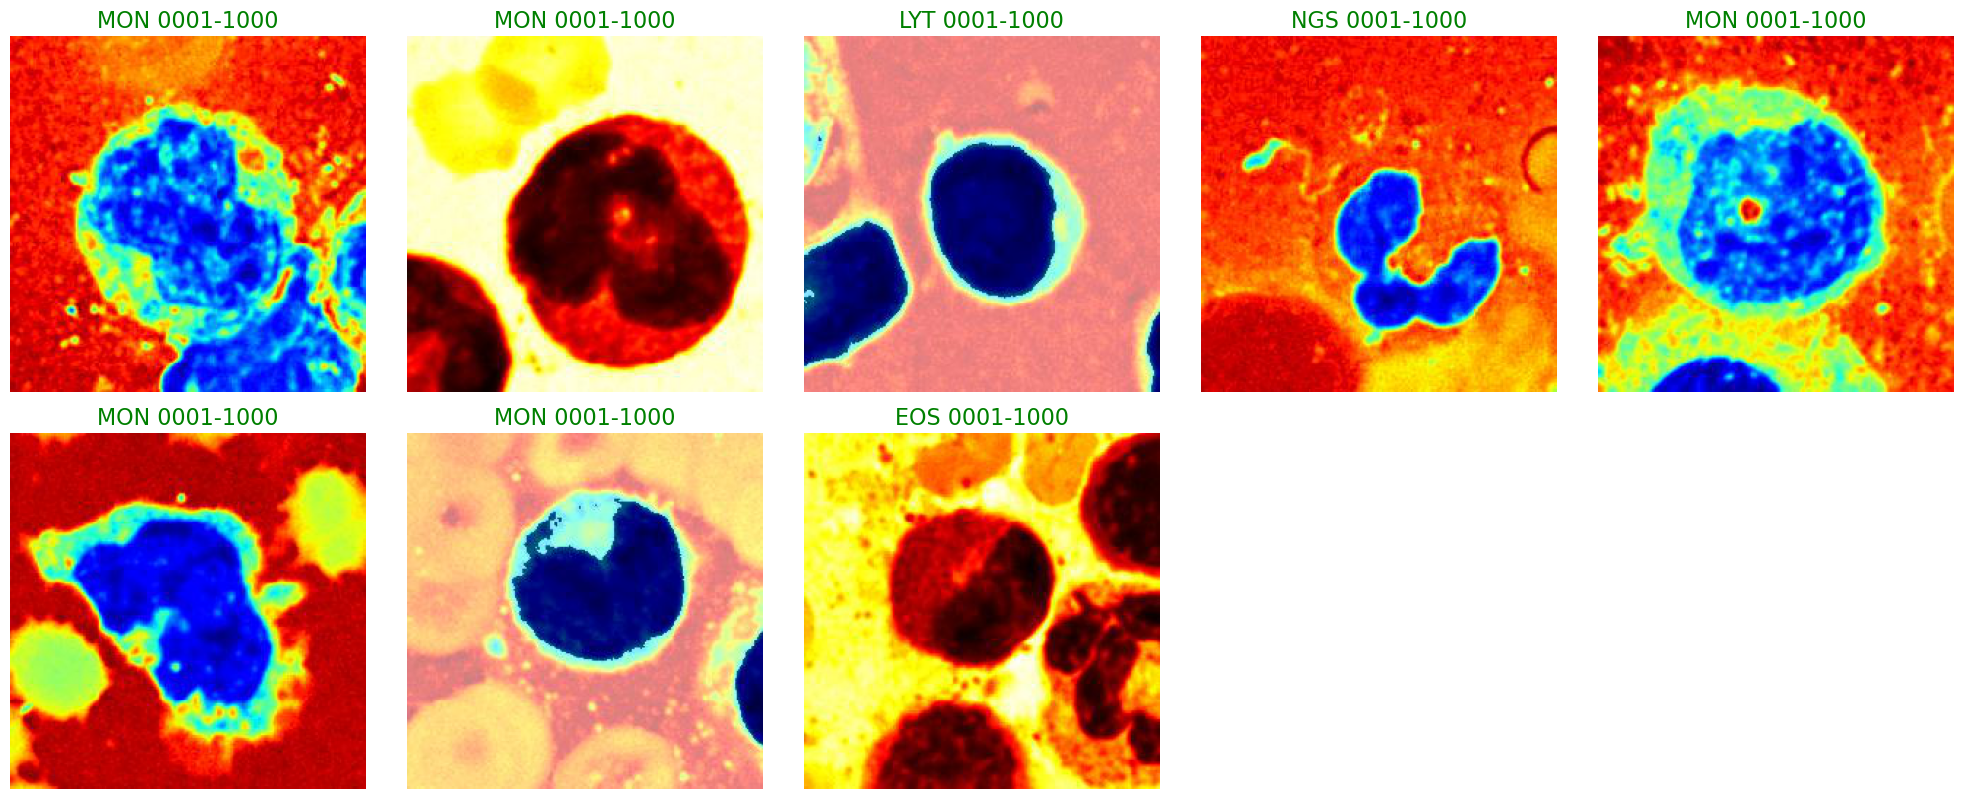

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def show_knee_images(image_gen):
    class_dict = image_gen.class_indices
    classes = list(class_dict.keys())

    images, labels = next(image_gen)
    print("Batch image shape:", images.shape)
    print("Batch label shape:", labels.shape)

    plt.figure(figsize=(20, 20))
    r = min(len(labels), 25)

    for i in range(r):
        plt.subplot(5, 5, i + 1)

        # Extract and normalize a single image (don't overwrite images!)
        image = images[i]
        image = (image + 1) / 2.0  # Only if MobileNetV2 preprocessing

        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color="green", fontsize=16)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
show_knee_images(train)
      

In [24]:
train_images, test_images = train_test_split(bloodcell_df, test_size =.3, random_state=42) 
train_set, val_set = train_test_split(bloodcell_df, test_size =0.2, random_state=42)

print(train_set.shape)

print(test_images.shape)

print(val_set.shape)

print(train_images.shape)

(640, 2)
(240, 2)
(160, 2)
(560, 2)


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with MobileNetV2 preprocessing
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

# Train Generator
train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="Filepaths",     # exact column name from DataFrame
    y_col="Labels",
    target_size=(244, 244),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)

# Test Generator
test = image_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col="Filepaths",     # exact column name from DataFrame
    y_col="Labels",
    target_size=(244, 244),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)

# Validation Generator
val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="Filepaths",     # exact column name from DataFrame
    y_col="Labels",
    target_size=(244, 244),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)


Found 640 validated image filenames belonging to 4 classes.
Found 240 validated image filenames belonging to 4 classes.
Found 160 validated image filenames belonging to 4 classes.


In [27]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.models.Sequential([
    keras.Input(shape=(224, 224, 3)),  # 👈 recommended way to define input
    layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3, 3)),
    layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 output classes
])
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 73, 73, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 73, 73, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 73, 73, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 12, 12, 512)         │           2,0

 Total params: 15,611,524 (59.55 MB)

 Trainable params: 15,605,124 (59.53 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [28]:
history = model.fit(train,epochs=5,validation_data=val,verbose=1)

Epoch 1/5


C:\Users\krant\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 313s 4s/step - accuracy: 0.2539 - loss: 2.7373 - val_accuracy: 0.2625 - val_loss: 1.3866
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 314s 4s/step - accuracy: 0.4049 - loss: 1.8277 - val_accuracy: 0.3000 - val_loss: 1.3765
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 317s 4s/step - accuracy: 0.4785 - loss: 1.4674 - val_accuracy: 0.4313 - val_loss: 1.1922
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 300s 4s/step - accuracy: 0.5440 - loss: 1.1266 - val_accuracy: 0.5375 - val_loss: 1.0603
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - accuracy: 0.5884 - loss: 1.0330 - val_accuracy: 0.6000 - val_loss: 0.9882


In [34]:
history1=model.fit(train,epochs=1,validation_data=val,verbose=1)

80/80 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.6831 - loss: 0.8098 - val_accuracy: 0.6313 - val_loss: 0.9673


In [39]:
pred=model.predict(test)
pred=np.argmax(pred, axis=1) #pick class with highest probability
labels=(train.class_indices)
labels=dict((y,k) for k,y in labels.items())
pred2=[labels[k] for k in pred]

30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step


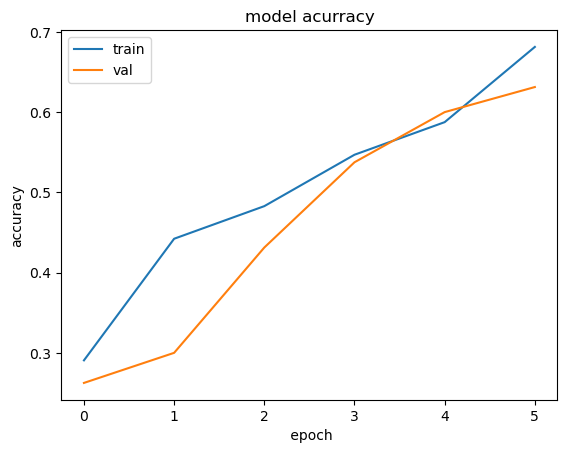

In [45]:
plt.plot(history.history ['accuracy'] + history1.history[ 'accuracy'])
plt.plot(history.history ['val_accuracy'] + history1.history['val_accuracy'])
plt.title("model acurracy")
plt.ylabel("accuracy")
plt .xlabel(' epoch')
plt.legend(['train', 'val'], loc="upper left")
plt.show()

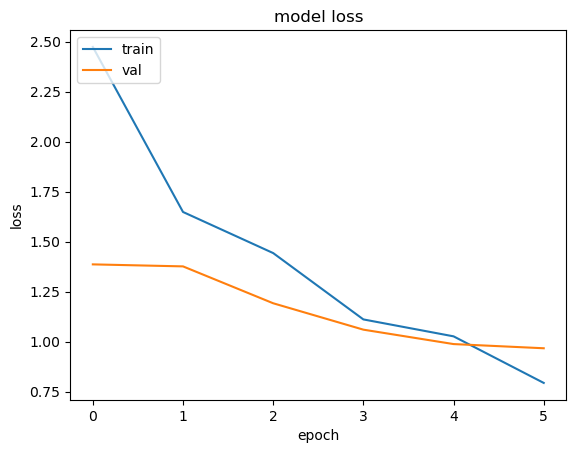

In [51]:
plt.plot(history.history['loss'] + history1.history ['loss'])
plt.plot(history.history['val_loss'] + history1.history ['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc= 'upper left')
plt.show()

In [63]:
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import classification_report

y_test = test_images.Labels  # Get ground truth labels
print(classification_report(y_test, pred2))  # Show precision, recall, f1-score
print("Accuracy of the Model:", "{:.1f}%".format(accuracy_score(y_test, pred2) * 100))


               precision    recall  f1-score   support

EOS 0001-1000       0.23      0.30      0.26        54
LYT 0001-1000       0.17      0.15      0.16        71
MON 0001-1000       0.16      0.12      0.14        65
NGS 0001-1000       0.22      0.24      0.23        50

     accuracy                           0.20       240
    macro avg       0.19      0.20      0.20       240
 weighted avg       0.19      0.20      0.19       240

Accuracy of the Model: 19.6%


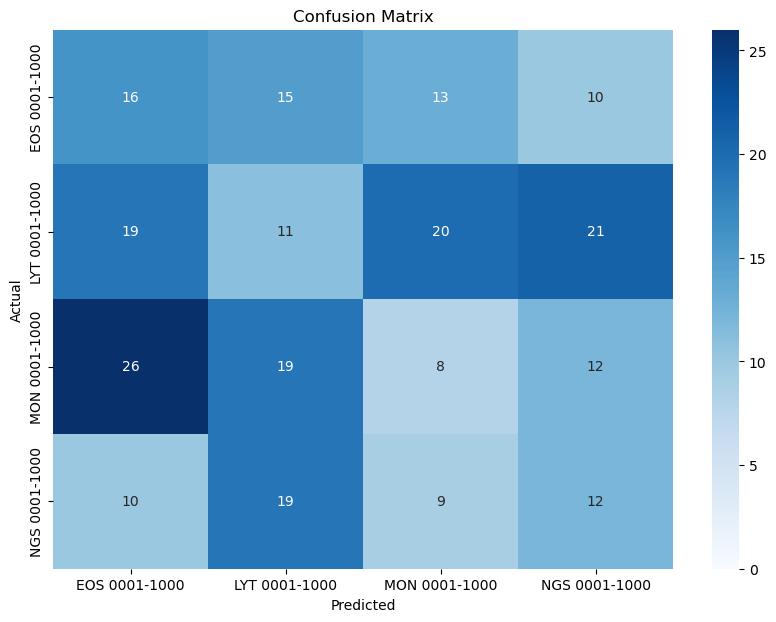

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
class_labels = ['EOS 0001-1000', 'LYT 0001-1000', 'MON 0001-1000', 'NGS 0001-1000']
cm= confusion_matrix(y_test, pred2)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot= True, fmt='g', vmin=0, cmap="Blues")
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels =class_labels)
plt.yticks(ticks= [0.5, 1.5, 2.5, 3.5], labels= class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [68]:
model.save('my_model.keras')  # Recommended
